In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
import scipy.integrate as integrate
import scipy.optimize as optimize
from scipy import interpolate

In [47]:
import os
import json
import scipy.optimize as optimize
class read_json_Suzuki_model_RWASM_T:
    
    def __init__(self,fh):
        if os.path.isfile(fh):
            self.file = fh
            self.data = json.load(open(fh))
        else:
            print('input file not in current directory')
            quit()
        
        self.model = self.data["model"]
        self.name = self.data["material"]
        # properties
        self.element_data = self.data['elements']
        # adjustable scalers
        self.adjustable_scalers = self.data['adjustables']
        # exp conditions
        self.experiment_conditions = self.data['conditions']
        # output file
        try: 
            self.savefilename = self.data['savefile']
        except:
            self.savefilename = self.data["material"] + '_out'
        

In [173]:
class Suzuki_model_RWASM_T:
    
    def __init__(self,
                element_data,
                experiment_conditions,
                adjustable_scalers):
        
        # 
        self.element_data = element_data
        # conditions
        self.strain_r = experiment_conditions['strain_r']
        self.T_range = np.arange(experiment_conditions['temperature']['min'],
                               experiment_conditions['temperature']['max']+experiment_conditions['temperature']['inc'],
                               experiment_conditions['temperature']['inc'])
        # constants
        self.boltzmann_J = 1.380649e-23
        self.boltzmann_eV = 8.617333262145e-5
        self.J2eV = self.boltzmann_eV/self.boltzmann_J
        self.eV2J = 1/self.J2eV
        self.Debye = 5 * 10**(12) # Debye frequency /s
        
        #adjustables
        self.rho = adjustable_scalers['dislocation_density']
        self.tau_i_exponent = adjustable_scalers['tau_i_exponent']
        self.trial_kappa_range = np.arange(adjustable_scalers['trial_kappa']['min'],
                                          adjustable_scalers['trial_kappa']['max']+adjustable_scalers['trial_kappa']['inc'],
                                          adjustable_scalers['trial_kappa']['inc'])
        self.trial_tau_k = adjustable_scalers['trial_tau_k'] * 1e6
        self.kink_width = adjustable_scalers['kink_width']

        
        
    def L(self,kappa_i):
        f = lambda x: np.exp(-x**2/2)/np.sqrt(2*np.pi)
        y = integrate.quad(f,kappa_i,np.inf)
        return self.b/(3*y[0]*self.c) 
    
    def tau_y_optimize(self,x):
        self.tau_j = lambda kappa_i: (self.E_int + self.E_vac)/(4*self.b*self.L(kappa_i))
        
        self.Delta_V = lambda x: 3 * x[1]**2 * self.E_w**2 * self.c / (2*x[0]**2*self.a_p*self.b**2) + \
                                     x[0]**2 * self.a_p**3 * self.b**4 * self.lambda_k**2 / (6*x[1]**2 * self.E_w**2 * self.c)
        self.S = lambda x: 18 * x[1]**2 * self.E_w**2 * self.c *self.kT /(self.a_p**3 * self.b**4 * self.lambda_k**2) * \
                 np.log( (5*np.pi*self.kT)**2 * self.Debye * self.a_p * self.b /((self.G*self.b*self.Delta_V(x))**2 * self.strain_r) )
        self.R = lambda kappa_i: 27 * kappa_i**4 * self.E_w**4 * self.c**2 / (self.a_p**4 * self.b**6 * self.lambda_k**2)
        # x[0] = tau_k
        # x[1] = kappa_i
        #self.tau_k_opt_func = lambda x: x[0]**4 + x[0]*self.S(x) - self.R(x[1]) 
        self.tau_y_funcs = lambda x: (self.tau_j(x[1]) + x[0], x[0]**4 + x[0]*self.S(x) - self.R(x[1]))
        self.res = optimize.root(self.tau_y_funcs, x)
        self.tau_k_value = self.res.x[0]
        self.tau_y_value = (self.res.x[0]) + self.tau_j(self.res.x[1])
        self.tau_j_value = self.tau_j(self.res.x[1])
        self.L_value = self.L(self.res.x[1])
        
    
    def phenomelogical_model_tau_y(self): 
        # tau_y = ( sum( tau_y_i**(1/q) ) )**q
        self.tau_y_tot = sum(self.tau_y_i**(1/self.tau_i_exponent))**self.tau_i_exponent
        
    def calculate(self):
        tau_y_tot_T = []
        tau_y_i_T_list = []
        tau_k_i_T_list = []
        tau_j_i_T_list = []
        self.elements_kappa_i_convergence_record = pd.DataFrame(data={})
        for element_symbol in self.element_data:
            self.elements_kappa_i_convergence_record[element_symbol] = {}
        for T in self.T_range:
            self.T = T
            self.kT = self.boltzmann_J * self.T
            # record tau_y for every element
            tau_y_i = []
            tau_k_i = []
            tau_j_i = []
            for element_symbol in self.element_data:
                element_i = self.element_data[element_symbol]
                #print(element_i)
                # calculate the yield strength contribution for every element
                # according to concentration
                # setup properties for every element
                self.E_f_v = element_i['E_f_v'] * self.eV2J #J
                self.E_f_si = element_i['E_f_si'] * self.eV2J # J
                self.a_0 = element_i['a']*1e-10#element_i['a_0'] * 10**(-10) # unit: m
                self.E_w = element_i['E_w'] * self.eV2J#element_i['E_w'] * self.eV2J # J
                self.c = element_i['c']
                self.G = element_i['G'] * 10**9 # Pa
                self.nu = element_i['nu']
                self.b = self.a_0 * np.sqrt(3) / 2
                self.a_p = self.a_0 * np.sqrt(2/3)
                #self.E_vac = 0.6 * self.eV2J / 10**(-10) # test NbTiZr
                #self.E_int = 0.9 * self.eV2J / 10**(-10) # test NbTiZr
                self.E_vac = 0.707 * self.E_f_v  /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
                self.E_int = 0.707 * self.E_f_si /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
                self.lambda_k = self.b * self.kink_width
                
                # record the optimization results for post-processing
                tau_k_list = []
                tau_j_list = []
                tau_y_list = []
                optimized_kappa_list = []
                
                # start to optimize tau_k for every trial kappa
                for trial_kappa_i in (self.trial_kappa_range):
                    
                    x_trial = [self.trial_tau_k, trial_kappa_i]
                    self.tau_y_optimize(x_trial)
                    tau_k_list.append(self.tau_k_value/1e6)
                    tau_j_list.append(self.tau_j_value/1e6)
                    tau_y_list.append(self.tau_y_value/1e6)
                    optimized_kappa_list.append((self.res.x[1]))
                
                # optimize tau_y over kappa, this finds the true tau_y for each element
                optimized_kappa_sort, tau_y_sort, tau_j_sort, tau_k_sort  = zip(*sorted(zip(optimized_kappa_list, tau_y_list, tau_j_list, tau_k_list)))
                '''
                # polyfit tau_y over kappa_i, then find minimum of the polyfit
                # this is because the kappa_list and tau_y_list are discrete points and maybe noisy, 
                # need a smooth curve to find min
                polyfit = np.polyfit(optimized_kappa_sort, tau_y_sort,9)
                npfit = np.poly1d(polyfit)
                guess_kappa = (self.trial_kappa_range[0]+self.trial_kappa_range[1])/2
                optimized_kappa = optimize.fmin_slsqp(npfit,guess_kappa,
                                                      bounds=([(self.trial_kappa_range[0],self.trial_kappa_range[-1])]))
                if self.T == 300:
                    plt.plot(optimized_kappa_sort, tau_y_sort)
                    print('optimized_kappa:',optimized_kappa)
                    plt.ylim(0,500)
                    plt.plot(self.trial_kappa_range,npfit(self.trial_kappa_range))
                # record tau_y for every element
                tau_y_i.append(npfit(optimized_kappa[0]))''' # doesn't work very well, need a better way. np.polyfit gets weird shape
                index = tau_y_sort.index(min(tau_y_sort))
                tau_y_i.append(min(tau_y_sort)) # just live with that...
                
                tau_k_i.append((tau_k_sort[index]))
                tau_j_i.append((tau_j_sort[index]))
                # record for convergence check
                self.elements_kappa_i_convergence_record[element_symbol]['kappa_'+str(self.T)] = None # strange thing here, only by setting None it records the first row of data
                self.elements_kappa_i_convergence_record[element_symbol]['tau_y_'+str(self.T)] = None
                self.elements_kappa_i_convergence_record[element_symbol]['kappa_'+str(self.T)] = optimized_kappa_sort
                self.elements_kappa_i_convergence_record[element_symbol]['tau_y_'+str(self.T)] = tau_y_sort
                # tau_k_i, tau_j_i dont add up to tau_y_tot
            tau_y_i_T_list.append(tau_y_i)
            tau_k_i_T_list.append(tau_k_i)
            tau_j_i_T_list.append(tau_j_i)

            self.tau_y_i = np.array(tau_y_i)
            self.phenomelogical_model_tau_y()
            tau_y_tot_T.append(self.tau_y_tot)
        self.tau_y_tot_T = np.array(tau_y_tot_T)
        self.tau_y_i_T_list = np.array(tau_y_i_T_list).transpose()
        self.tau_k_i_T_list = np.array(tau_k_i_T_list).transpose()
        self.tau_j_i_T_list = np.array(tau_j_i_T_list).transpose()
    def writedata(self):
        self.calc_data = pd.DataFrame(data=
                                     {
                                         "T": self.T_range,
                                         "tau_y": np.round(self.tau_y_tot_T,2)
                                     })
        for i, element_symbol in zip(range(len(self.element_data)),self.element_data):
            self.calc_data["tau_y_"+str(element_symbol)] = np.round(self.tau_y_i_T_list[i],2)
            self.calc_data["tau_k_"+str(element_symbol)] = np.round(self.tau_k_i_T_list[i],2)
            self.calc_data["tau_j_"+str(element_symbol)] = np.round(self.tau_j_i_T_list[i],2)


In [174]:
input_data = read_json_Suzuki_model_RWASM_T('../sample_input_TiNbZr_BCC_screw_suzuki.json')


In [175]:
list(input_data.element_data.keys())[0]

'Nb'

In [176]:
model = Suzuki_model_RWASM_T(input_data.element_data,
                            input_data.experiment_conditions,
                            input_data.adjustable_scalers)

In [177]:
model.calculate()

In [178]:
model.writedata()

(0, 1200)

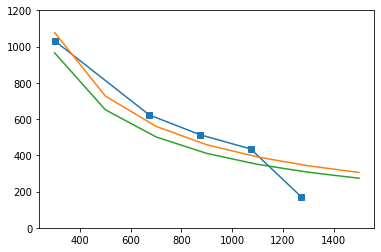

In [179]:
paper_data = [
1032.146606445312,
622.820007324219,
513.924377441406,
434.880462646484,
169.899871826172,
]
plt.plot([300,673,873,1073,1273],paper_data,'-s',label='paper')

plt.plot(model.T_range,np.array(model.tau_y_tot_T)*3.07)
plt.plot(model.T_range,np.array(model.tau_y_tot_T)*2.75)
plt.ylim(0,1200)

In [180]:
model.calc_data

,T,tau_y,tau_y_Nb,tau_k_Nb,tau_j_Nb,tau_y_Ti,tau_k_Ti,tau_j_Ti,tau_y_Zr,tau_k_Zr,tau_j_Zr
0,300,350.96,172.03,144.05,27.98,57.02,48.33,8.69,121.91,100.25,21.66
1,500,236.83,116.17,96.51,19.66,38.10,32.71,5.39,82.56,69.51,13.04
2,700,182.29,89.56,73.02,16.54,29.15,25.31,3.85,63.58,54.15,9.43
3,900,149.24,73.18,62.75,10.43,23.85,20.69,3.16,52.22,44.40,7.82
4,1100,127.34,62.43,54.24,8.20,20.31,17.92,2.39,44.59,37.94,6.65
5,1300,111.49,54.66,47.40,7.25,17.76,15.52,2.23,39.08,33.55,5.53
6,1500,99.48,48.76,42.26,6.50,15.82,13.97,1.85,34.89,30.06,4.83


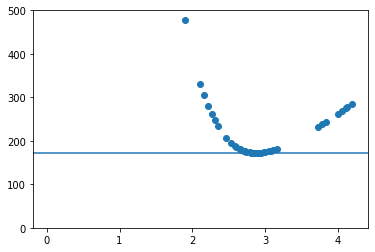

In [183]:
x = model.elements_kappa_i_convergence_record['Nb']['kappa_300']
y = model.elements_kappa_i_convergence_record['Nb']['tau_y_300']

plt.scatter(x,y)
plt.ylim(0,500)
plt.axhline(min(y))

In [184]:
model.elements_kappa_i_convergence_record['Nb']

tau_y_300     (7007.1808491300735, 6877.267194909293, 6863.3...
kappa_300     (0.030650575758885752, 0.04597643234620123, 0....
kappa_500     (0.32003990443973107, 0.388868834610391, 0.395...
tau_y_500     (5189.099507742568, 4791.431069540042, 4751.71...
kappa_700     (0.14943029960225804, 0.1569371707104257, 0.16...
tau_y_700     (6203.002388225677, 6156.151847271378, 6104.73...
kappa_900     (0.07632187398361209, 0.14574527992862563, 0.1...
tau_y_900     (6658.819924389374, 6214.863441092322, 6152.09...
kappa_1100    (0.5131660345387348, 0.5200368050148777, 0.546...
tau_y_1100    (4367.800276797217, 4333.387747429811, 4200.15...
kappa_1300    (0.5025133002731846, 0.508289689307719, 0.5141...
tau_y_1300    (4421.146233121793, 4392.042754079106, 4362.76...
kappa_1500    (0.5018660428955636, 0.5723887425587091, 0.624...
tau_y_1500    (4424.227223187296, 4074.764316307921, 3825.25...
Name: Nb, dtype: object

In [186]:
model.elements_kappa_i_convergence_record['Nb'].to_dict()

{'tau_y_300': (7007.1808491300735,
  6877.267194909293,
  6863.335227197719,
  6732.435826144349,
  6515.726516191985,
  2297.5340575330383,
  2129.5467008468063,
  1970.28553544048,
  1819.6970624295323,
  1677.6890866529927,
  1608.8828394976924,
  1073.378979262399,
  971.7091675322406,
  958.2422577460796,
  878.8789387653504,
  871.9141455814467,
  789.5910412774022,
  714.5046376710985,
  646.2528385382118,
  584.4351065387351,
  528.654458441396,
  478.5200298105145,
  331.21251901598924,
  305.78487566084465,
  280.97928343759287,
  261.42550831295614,
  247.02947185985548,
  234.34310009389426,
  205.7334352717892,
  195.75704433003364,
  187.2171448518017,
  185.15181976296907,
  180.64067266552365,
  180.5353719859636,
  179.08669027816964,
  176.29732063616794,
  176.23929223888163,
  175.72739268276848,
  174.93894028236224,
  173.20733445290054,
  172.85318579493975,
  172.22036056017666,
  172.11872222137578,
  172.02669236129825,
  172.07199433834518,
  172.257708798181